In [1]:
import pandas as pd
import numpy as np
import shap
import math, random

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Tratamento dos dados

In [2]:
dataset = pd.read_csv('housing_price_dataset.csv')

In [3]:
df = dataset.copy()
df.sample(5)

,area,n_quartos,n_banheiros,vizinhanca,ano_contrucao,preco
21971,1213,4,2,Urban,1970,69327.255595
37541,1284,3,1,Suburb,1963,78948.130854
3894,1724,2,3,Urban,1971,161809.194901
37656,1898,3,3,Suburb,1962,225410.200685
7271,1967,4,3,Urban,2000,293841.786468


In [4]:
df.describe()

,area,n_quartos,n_banheiros,ano_contrucao,preco
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2006.374680,3.498700,1.995420,1985.404420,224827.325151
std,575.513241,1.116326,0.815851,20.719377,76141.842966
min,1000.000000,2.000000,1.000000,1950.000000,-36588.165397
25%,1513.000000,3.000000,1.000000,1967.000000,169955.860225
50%,2007.000000,3.000000,2.000000,1985.000000,225052.141166
75%,2506.000000,4.000000,3.000000,2003.000000,279373.630052
max,2999.000000,5.000000,3.000000,2021.000000,492195.259972


In [5]:
df['vizinhanca'].value_counts()

vizinhanca
Suburb    16721
Rural     16676
Urban     16603
Name: count, dtype: int64

In [6]:
dicionario = {
    'Suburb': 'Suburbio',
    'Rural': 'Rural', 
    'Urban': 'Urbano'
}
# trocar os valores da coluna 'vizinhanca' para português
df['vizinhanca'] = df['vizinhanca'].replace(dicionario)

In [7]:
df['area'] = round(df['area']/10.7639, 2)
df['preco'] = round(df['preco'], 2)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   area           50000 non-null  float64
 1   n_quartos      50000 non-null  int64  
 2   n_banheiros    50000 non-null  int64  
 3   vizinhanca     50000 non-null  object 
 4   ano_contrucao  50000 non-null  int64  
 5   preco          50000 non-null  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 2.3+ MB


In [9]:
df.to_csv('housing_price_dataset_2.csv', index=False)

# Análise dos dados

In [10]:
df = pd.read_csv('housing_price_dataset_2.csv')

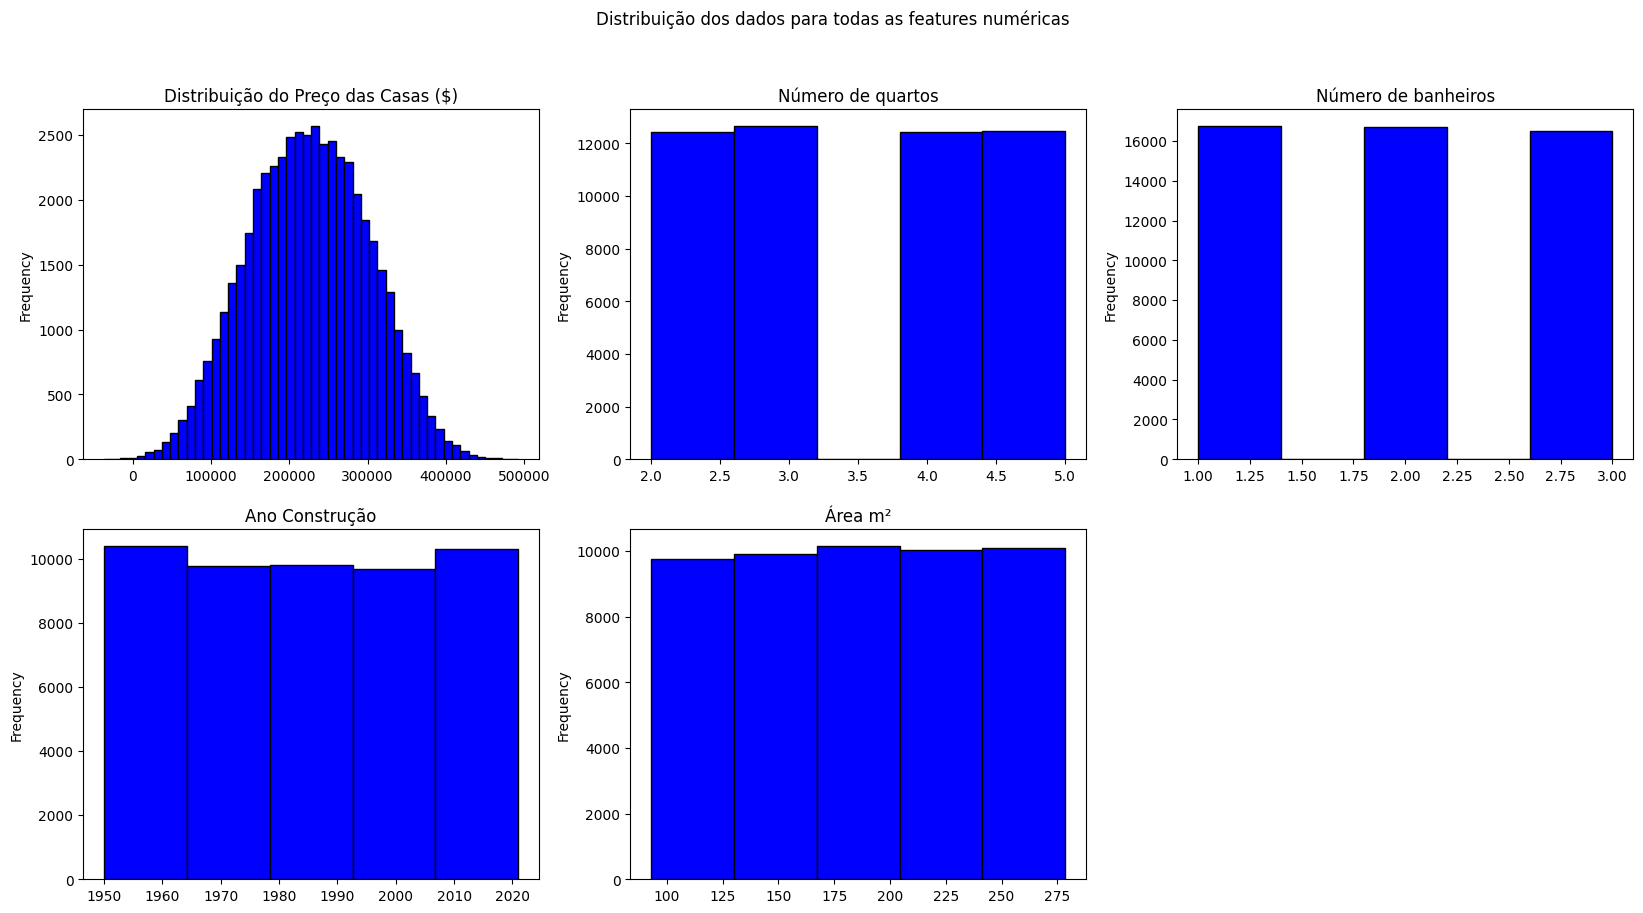

In [11]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 3, 1)
df['preco'].plot(kind='hist', bins=50, color='blue', edgecolor='black')
plt.title('Distribuição do Preço das Casas ($)')

plt.subplot(2, 3, 2)
df['n_quartos'].plot(kind='hist', bins=5, color='blue', edgecolor='black')
plt.title('Número de quartos')

plt.subplot(2, 3, 3)
df['n_banheiros'].plot(kind='hist', bins=5, color='blue', edgecolor='black')
plt.title('Número de banheiros')

plt.subplot(2, 3, 4)
df['ano_contrucao'].plot(kind='hist', bins=5, color='blue', edgecolor='black')
plt.title('Ano Construção')

plt.subplot(2, 3, 5)
df['area'].plot(kind='hist', bins=5, color='blue', edgecolor='black')
plt.title('Área m²')

plt.suptitle('Distribuição dos dados para todas as features numéricas')

plt.show()

- Distribuição normal, típica.
---

# Treinamento

In [12]:
def preparar_dataset(test_size_ = 0.2):

    df = pd.read_csv('housing_price_dataset_2.csv')

    # encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, )
    # vetor_codificado = encoder.fit_transform(df[['vizinhanca']])
    # nomes_features = list(encoder.get_feature_names_out())
    # df_vizinhanca = pd.DataFrame(data=vetor_codificado, columns=nomes_features).astype(np.int0)
    # df = pd.concat([df, df_vizinhanca], axis=1)
    df.drop(columns=['vizinhanca'], inplace=True)

    x = df.drop(columns=['preco'])
    y = df['preco']

    feature_names = x.columns

    scaler = MinMaxScaler(feature_range=(-1, 1))
    yscaler = MinMaxScaler(feature_range=(0, 1))

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = test_size_)

    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    # y_train = yscaler.fit_transform(np.array(y_train).reshape(-1, 1))
    # y_test = yscaler.transform(np.array(y_test).reshape(-1, 1))

    return x_train, x_test, y_train, y_test, scaler, yscaler, feature_names

In [13]:
x_train, x_test, y_train, y_test, scaler, yscaler, FEATURE_NAMES = preparar_dataset()

model = LinearRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print (f'mae={mae:0.2f}\nmse={mse:0.2f}\nrmse={rmse:0.2f}\nr2={r2:0.2f}')


mae=39611.15
mse=2465860989.98
rmse=49657.44
r2=0.58


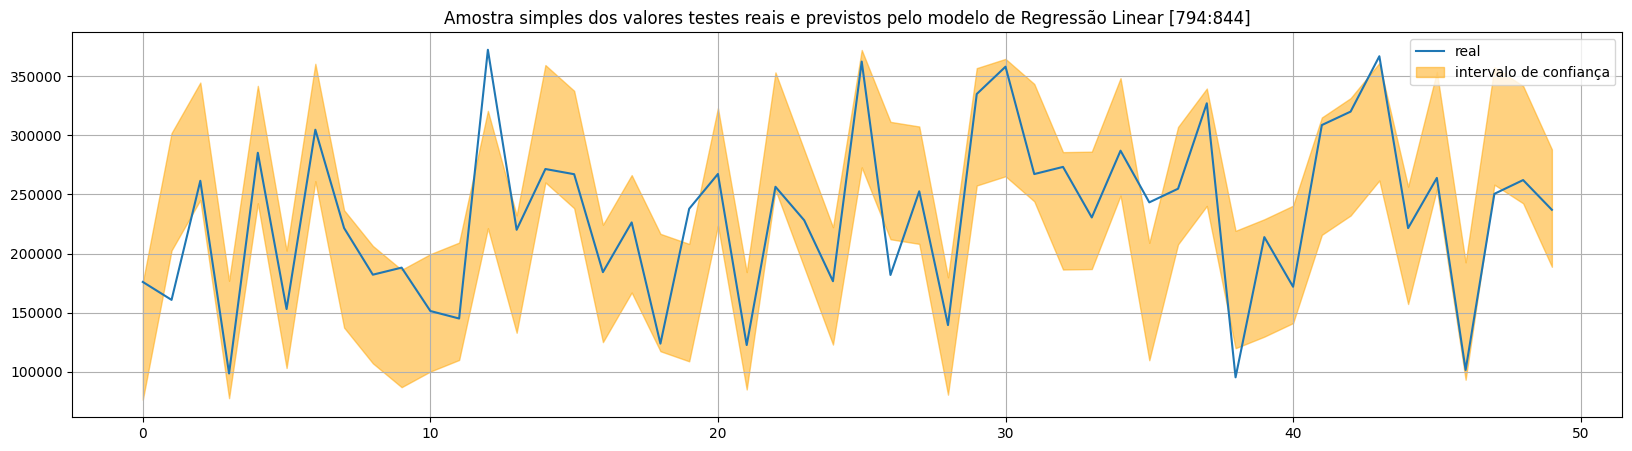

In [14]:
plt.figure(figsize=(20, 5))

n = 50
n1 = np.random.randint(0, len(y_test) - n - 1)
n2 = n1+n

plt.plot(np.arange(n), y_test[n1:n2], label='real')

y_superior = y_pred + rmse
y_inferior = y_pred - rmse

plt.fill_between(np.arange(n), y_superior[n1:n2], y_inferior[n1:n2], color='orange', alpha=0.5, label='intervalo de confiança')
plt.grid()

plt.legend()
plt.title(f'Amostra simples dos valores testes reais e previstos pelo modelo de Regressão Linear [{n1}:{n2}]')

plt.show()

- O que significa esse gráfico?  
- Significa que foram sorteadas 50 instâncias e plotamos na linha azul o valor real, enquanto que a sobra laranja representa o intervalo do valor predito máximo e predito mínimo. Ou seja, pegamos o valor y_pred e fizemos duas curvas: y_pred + rmse e y_pred - rmse. Essas duas curvas representam uma faixa possível de variação da previsão e não é um intervalo de confiança no sentido estatístico formal (como um intervalo de 95%). Um intervalo de confiança tem uma probabilidade específica de conter o valor real, enquanto o RMSE é apenas uma medida da dispersão dos erros.
---

# Shap Values

In [15]:
shap.initjs()

In [16]:
x_train, x_test, y_train, y_test, scaler, yscaler, FEATURE_NAMES = preparar_dataset(test_size_=0.995)
print (f'{x_train.shape=}\n{y_train.shape=}')

x_train.shape=(250, 4)
y_train.shape=(250,)


In [17]:
explainer = shap.LinearExplainer(model, x_train)

In [18]:
shap_values = explainer.shap_values(pd.DataFrame(x_test).sample(250))
shap_values.shape

(250, 4)

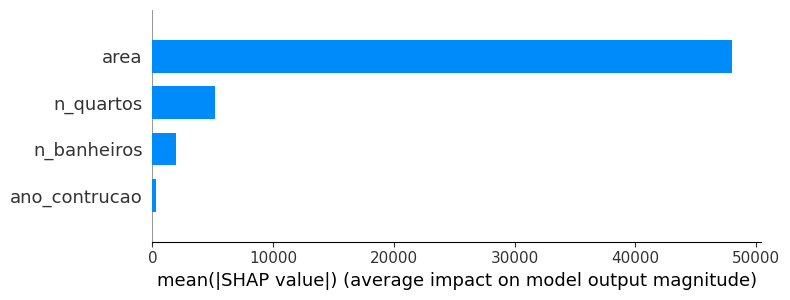

In [19]:
shap.summary_plot(shap_values, x_test, plot_type="bar", feature_names=FEATURE_NAMES) # Gráfico de barras da importância das features

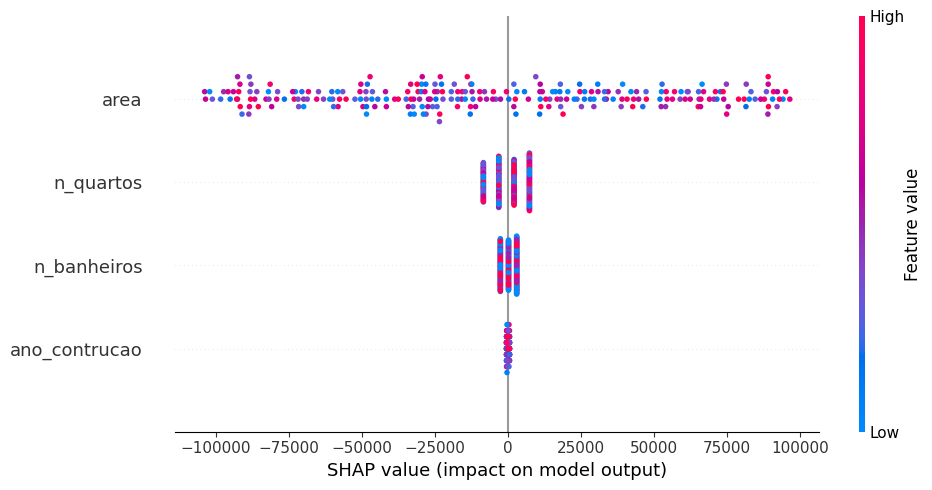

In [20]:
# Gráfico 1 - Contribução das variáveis
shap.summary_plot(
    shap_values, # <<<<< aqui estamos pegando o resultado da classe 1 (diabetes)
    x_train, 
    plot_type="dot", 
    plot_size=(10, 5), 
    feature_names=FEATURE_NAMES,
    title="SHAP - Contribuição das variáveis para o modelo de Random Forest",
)

In [21]:
print (f'expected value: {explainer.expected_value:0.2f}')

expected value: 228466.16


Shap Values para n=190


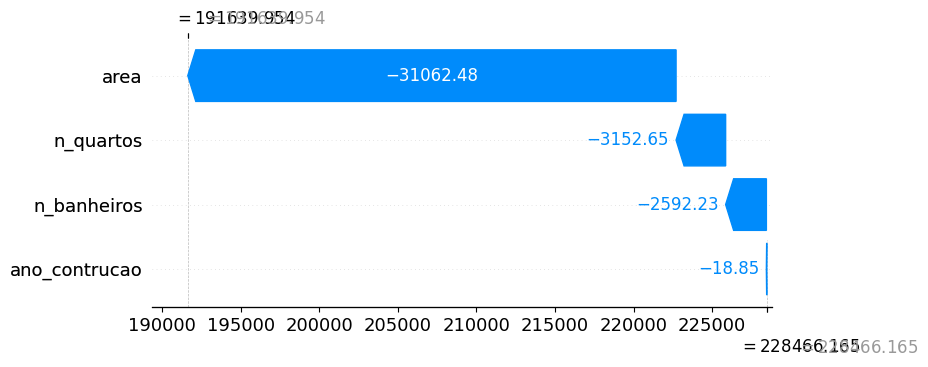

In [38]:
n = random.randint(0, len(shap_values) - 1)
print (f'Shap Values para {n=}')


shap.plots._waterfall.waterfall_legacy(
    expected_value = explainer.expected_value, 
    shap_values = shap_values[n], 
    feature_names = FEATURE_NAMES
)